# Knowledge Tracing without Time Information

In [1]:
import itertools
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import os
import random

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"CUDA available: {use_cuda}")
print(f"MPS available: {use_mps}")
print(f"Using device: {device}")

CUDA available: False
MPS available: True
Using device: cpu


In [3]:
def set_seed(seed):
    random.seed(seed)  # Pythonのrandomモジュールのシードを固定
    np.random.seed(seed)  # NumPyのシードを固定
    torch.manual_seed(seed)  # PyTorchのCPUシードを固定
    torch.cuda.manual_seed(seed)  # PyTorchのGPUシードを固定
    torch.cuda.manual_seed_all(seed)  # マルチGPU環境でのシード固定
    torch.backends.cudnn.deterministic = True  # 再現性のためにCuDNNを固定
    torch.backends.cudnn.benchmark = False  # 再現性のためにCuDNNベンチマークをOFF

set_seed(1)

## 人工データ生成

### スキル間の依存関係定義

In [4]:
"""
・各スキルの依存関係行列を作る
・初期状態から遷移する数を1からn/2の範囲で指定
・各列に着目し、親ノードに繋がるように調整
・何かしらの子ノードを持つように調整
"""
def dependency_matrix(n): # n: 要素数

    # 下三角行列をランダム生成（対角成分は0にする）
    A = np.tril(np.random.randint(0, 2, (n, n)), k=-1).astype(float)

    # 初期状態からの遷移をいくつ作るか
    init = np.random.randint(1, int(n / 2)+1) # [1, n/2+1)
    for i in range(init):
        A[i] = 0
    
    # 要素j=0,...,n-2は、要素j+1,...,n-1に依存するように調整
    for j in range(n-1):
        if not A[:, j].any():  # 先に依存関係がない場合
            c = np.random.randint(j+1, n)  # ランダムに行を選択
            A[c, j] = 1
            
    # 各ノードが必ず1つの依存関係を持つように調整
    for k in range(init, n):  # 最後のノード以外をチェック
        if not A[k, :].any():  # 出次数が0のノードを確認
            # ランダムに依存関係を作る
            d = np.random.randint(0, k)  # 1からi-1までの数字から選択
            A[k, d] = 1
    return A

# # 依存関係行列
# A = np.array([
#     [0, 0, 0, 0, 0, 0],  # 0番目の要素は無視
#     [1, 0, 0, 0, 0, 0],  # 要素1は状態に依存しない
#     [1, 0, 0, 0, 0, 0],  # 要素2は状態に依存しない
#     [0, 1, 1, 0, 0, 0],  # 要素3は要素1と2に依存
#     [0, 0, 0, 1, 0, 0],  # 要素4は要素3に依存
#     [0, 0, 0, 0, 1, 0]   # 要素5は要素4に依存
# ], dtype = float)*3

# # 0でない要素の数で割る処理
# nonzero_counts = np.count_nonzero(A[1:], axis=1, keepdims=True)
# A[1:] = np.where(nonzero_counts != 0, A[1:] / nonzero_counts, 0)

# num_components = len(A)-1  # 要素数

### 遷移確率

In [5]:
# 次ノードへの遷移確率を計算
def transition_probabilities(A, X, guessing=0.3):
    """
    Aは要素の依存関係を表す行列、Xは状態ベクトル
    """
    n = len(X)
    probabilities = np.zeros(n)  # 初期化
    
    # 各要素(0)の習得遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 未習得が対象
            probabilities[i] = DINA(A[i, :], X)

    # 条件を満たしたもの(1)のみを対象にsoftmax
    mask = (probabilities != 0)
    non_zero_values = probabilities[mask]
    normalized_non_zero = softmax(non_zero_values)

    # guessingを考慮
    probabilities[mask] = (1-guessing) * normalized_non_zero
    mask2 = (X == 0)
    probabilities[mask2] += guessing / mask2.sum()
    return probabilities

def DINA(Ai, X):
    """
    Ai:要素iに必要な条件ベクトル{0,1}
    X:習得状態ベクトル{0,1}
    """
    mask = (Ai != 0) # 0でない要素のみ
    dina = np.min(X[mask] * Ai[mask]) if np.any(mask) else 1 # 全て習得もしくは必要条件がない場合は1
    return dina

def DINO(Ai, X):
    """共にベクトル
    """
    dino = np.sum(X * Ai) # 要素を持つほど大きい
    return dino

def softmax(x):
    exp_x = np.exp(x - np.max(x)) # オーバーフロー対策
    return exp_x / exp_x.sum(axis=0, keepdims=True)

### データ生成

In [6]:
# 人工データ生成
def generate_data_all(A, n_students):
    """
    A:各スキルの習得に必要な依存関係を表した行列
    n_students:生成するデータ数（学生数）
    """
    n_questions = len(A) # 要素数

    # 各学生の正解数をベータ分布に従って生成
    alpha = 2.5 # （正解率を高めに作るなら alpha > beta）
    beta = 2.5
    ps = np.random.beta(alpha, beta, size=n_students) # ベータ分布に従う正解率
    skill_counts = [np.random.binomial(n_questions, p) for p in ps] # 整数値にする
    growth_counts = np.random.binomial(n_questions//2, 0.6, size=n_students) #　将来の追加正解数。p=0.6の二項分布に従う。

    initial_X = np.array([0] * n_questions) # 初期状態
    dataset = []
    dataset_step = []
    dataset_all = []

    # 学生iのデータを生成
    for i in range(n_students): # 習得数
        growth = np.minimum(growth_counts[i], n_questions - skill_counts[i])
        X = initial_X.copy()
        initial_X_step = initial_X.copy()
        data_1 = initial_X.copy()
        for j in range(skill_counts[i] + growth): # 遷移数
            pre_X = X.copy()  # 遷移前の状態
            probabilities = transition_probabilities(A, X)
            next_skill = np.random.choice(n_questions, p=probabilities)
            X[next_skill] = 1

            # 学生iの習得状態
            if j + 1 == skill_counts[i]:
                data_1 = X.copy()

            # skill_counts[i]が0の時は考慮してない
            if j + 1 <= skill_counts[i]:
                # 中間パスを記録
                if j + 1 == skill_counts[i]//2:
                    X_step = X - initial_X_step
                    dataset_step.append((initial_X_step.copy(), X_step.copy()))
                    initial_X_step = X.copy()
                if j + 1 == skill_counts[i]:
                    X_step = X - initial_X_step
                    dataset_step.append((initial_X_step.copy(), X_step.copy()))

                # 全てのパスを記録
                all_X = X - pre_X
                dataset_all.append((pre_X.copy(), all_X.copy()))
        
        # 最終的な状態を教師データとして使用
        data_2 = X - data_1
        dataset.append((initial_X.copy(), data_1.copy(), data_2.copy()))
    return dataset, dataset_step, dataset_all

## モデル

### アーキテクチャ

In [7]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [8]:
bcsoftmax1d = BCSoftmax1d.apply
# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, n_skills):
        super(Model, self).__init__()
        self.fc = nn.Linear(n_skills, n_skills)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

### 学習・評価

In [9]:
def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

def train(model, n_skills, device, X_train, y_val, criterion, optimizer, hyp, reg):
    model.train()

    outputs = []
    relu = nn.ReLU()
    # データによってループ回数が異なる
    for i, target in enumerate(y_val):
        # 初期budget
        c = torch.ones(n_skills, dtype=torch.float32, device=device)
        c = c - X_train[i]
        state = X_train[i].to(device) # .to(device)は新しいテンソルを返す処理だから.clone()は不要

        # 習得数だけループ
        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となってしまう
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)  # 状態から遷移確率を計算
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # budgetの更新

        outputs.append(state - X_train[i])  # 最終的な出力を保存
    
    outputs = torch.stack(outputs) # 全て合わせる

    # 正則化項
    loss_o = criterion(outputs, y_val)
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss)

def val_loss(model, n_skills, device, X_val, y_val, criterion, hyp, reg):
    model.eval()
    relu = nn.ReLU()

    with torch.no_grad():
        val_outputs = []
        for i, target in enumerate(y_val):
            c = torch.ones(n_skills, dtype=torch.float32, device=device)
            c = c - X_val[i]
            state = X_val[i].to(device)

            # 習得数だけループ
            for _ in range(int(sum(target))):
                # もしcの和が1なら、rが0となってしまう
                if c.sum() <= 1:
                    prob = c
                else:
                    prob = model(state, c)  # 状態から遷移確率を計算
                state = prob + state  # 状態の更新
                c = relu(c - prob)  # 予算の更新

            val_outputs.append(state - X_val[i])

        val_outputs = torch.stack(val_outputs)

        # 正則化項
        loss_o = criterion(val_outputs, y_val)
        if reg == 'L1':
            loss = loss_o + hyp * l1(model)
        elif reg == 'L2':
            loss = loss_o + hyp * l2(model)
        else:
            loss = loss_o

    return float(loss)

def train_model(args, n_skills, model, X_train, y_train, X_val, y_val, criterion, optimizer):
    # 試行ごとのロスを記録
    training_losses = []
    validation_losses = []
    # ロスの初期化
    best_loss = float('inf')
    count = 0 # 早期終了のカウント
    for epoch in range(args.epochs):
        train_loss = train(model, n_skills, device, X_train, y_train, criterion, optimizer, args.hyperparameter, args.Regularization)
        valid_loss = val_loss(model, n_skills, device, X_val, y_val, criterion, args.hyperparameter, args.Regularization)
        best_loss = min(best_loss, valid_loss)
        
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

        if best_loss < valid_loss:
            count += 1
        else:
            count = 0
            # torch.save(model.state_dict(), f"{model}_{args}.pth") # モデルの保存
            
        if count >= args.early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation loss: {best_loss:.4f}")
    return training_losses, validation_losses

### データ分割

In [10]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 7:3に分割
def split_balanced_data(train_X, train_Y, ratio=0.7):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    X_train, y_train, X_val, y_val = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        X_train.extend([x for x, _ in train_data])
        y_train.extend([y for _, y in train_data])
        X_val.extend([x for x, _ in val_data])
        y_val.extend([y for _, y in val_data])
    return X_train, y_train, X_val, y_val

### その他評価指標

#### KL Divergence

$$ D_{\text{KL}}(p \| q) = \sum_{i} p(i) \log \frac{p(i)}{q(i)} $$

---

#### Hellinger距離

$$ H(p, q) = \frac{1}{\sqrt{2}} \left\| \sqrt{p} - \sqrt{q} \right\|_2 $$

$$ \left\| \sqrt{p} - \sqrt{q} \right\|_2 = \sqrt{\sum_{i} \left( \sqrt{p(i)} - \sqrt{q(i)} \right)^2} $$

---

#### Jensen-Shannon Divergence

$$ D_{\text{JS}}(p \| q) = \frac{1}{2} D_{\text{KL}}(p \| m) + \frac{1}{2} D_{\text{KL}}(q \| m) $$

$$ m = \frac{1}{2}(p + q) $$

In [11]:
def kl_divergence(p, q, epsilon=1e-10):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # pとqにスムージングを適用
    p = np.where(p == 0, epsilon, p)
    q = np.where(q == 0, epsilon, q)
    
    # KLダイバージェンスの計算
    return np.sum(p * np.log(p / q))

def hellinger_distance(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    # Hellinger距離の計算式: H(p, q) = (1/√2) * ||√p - √q||_2
    sqrt_p = np.sqrt(p)
    sqrt_q = np.sqrt(q)
    distance = np.sqrt(np.sum((sqrt_p - sqrt_q) ** 2)) / np.sqrt(2)
    return np.mean(distance)

def js_divergence(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    m = 0.5 * (p + q)
    jsd = 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))
    
    # 各サンプルの平均を返す
    return np.mean(jsd)
    

In [12]:
def evaluate(models_dict, n_skills, A, data_1, comparison=True):
    for model in models_dict.values():
        model.eval()

    node_probabilities = defaultdict(float)
    start = tuple(0 for _ in range(n_skills))
    node_probabilities[start] = 1

    # スコア格納辞書
    metrics = {
        "difficulty_KL": 0.0,
        "difficulty_HD": 0.0,
        "difficulty_JSD": 0.0,
        "count_KL": 0.0,
        "count_HD": 0.0,
        "count_JSD": 0.0,
        "uniform_KL": 0.0,
        "uniform_HD": 0.0,
        "uniform_JSD": 0.0,
    }

    model_metrics = {name: {"KL": 0.0, "HD": 0.0, "JSD": 0.0} for name in models_dict}


    "全ての状態を定義"
    states = [state for state in itertools.product([0, 1], repeat=n_skills)]
    states = sorted(states, key=lambda state: sum(state))

    # 状態ごとの学生数をカウント（出現回数ベース）
    state_counts = defaultdict(int)
    for i in range(len(data_1)):
        state_tuple = tuple(map(int, data_1[i]))
        state_counts[state_tuple] += 1

    for state in states:
        if state == (1,) * n_skills: # 全て習得なら終わり
            continue

        # 遷移確率
        probabilities = transition_probabilities(A, np.array(state))

        # c_pred（出現回数ベース）
        c_pred = []
        c_total = 0
        for i in range(n_skills):
            if state[i] == 0:
                next_state = list(state)
                next_state[i] = 1
                next_state = tuple(next_state)
                node_probabilities[next_state] += probabilities[i] * node_probabilities[state]
                c_pred.append(state_counts[next_state])
                c_total += state_counts[next_state]
            else:
                c_pred.append(0)

        # 状態とbudget
        relu = nn.ReLU()
        c_g = torch.ones(n_skills, dtype=torch.float32)
        c_g = relu(c_g - torch.tensor(state, dtype=torch.float32))
        state_tensor = torch.tensor(state, dtype=torch.float32)

        # 比較モデルのスコア
        for name, model in models_dict.items():
            with torch.no_grad():
                pred = model(state_tensor, c_g)
            model_metrics[name]["KL"] += node_probabilities[state] * kl_divergence(probabilities, pred)
            model_metrics[name]["HD"] += node_probabilities[state] * hellinger_distance(probabilities, pred)
            model_metrics[name]["JSD"] += node_probabilities[state] * js_divergence(probabilities, pred)

        # 難易度ベース
        difficulties = np.sum(np.array(data_1), axis=0)
        candidate_indices = np.where(np.array(state) == 0)[0]
        difficulties_pred = np.zeros_like(difficulties, dtype=np.float64) # 同じ形状の全て0の配列
        difficulties_pred[candidate_indices] = difficulties[candidate_indices]
        difficulties_pred /= difficulties_pred.sum() if difficulties_pred.sum() != 0 else 1

        metrics["difficulty_KL"] += node_probabilities[state] * kl_divergence(probabilities, difficulties_pred)
        metrics["difficulty_HD"] += node_probabilities[state] * hellinger_distance(probabilities, difficulties_pred)
        metrics["difficulty_JSD"] += node_probabilities[state] * js_divergence(probabilities, difficulties_pred)

        # 回数ベース
        if c_total > 0:
            c_pred = np.array(c_pred) / c_total
        metrics["count_KL"] += node_probabilities[state] * kl_divergence(probabilities, c_pred)
        metrics["count_HD"] += node_probabilities[state] * hellinger_distance(probabilities, c_pred)
        metrics["count_JSD"] += node_probabilities[state] * js_divergence(probabilities, c_pred)

        # 一様分布
        uniform_pred = np.zeros(n_skills)
        uniform_pred[candidate_indices] = 1 / len(candidate_indices)
        metrics["uniform_KL"] += node_probabilities[state] * kl_divergence(probabilities, uniform_pred)
        metrics["uniform_HD"] += node_probabilities[state] * hellinger_distance(probabilities, uniform_pred)
        metrics["uniform_JSD"] += node_probabilities[state] * js_divergence(probabilities, uniform_pred)

    # 出力形式の整理
    if comparison:
        result = [float(model_metrics[name]["KL"]) for name in models_dict] + \
        [float(metrics["difficulty_KL"]), float(metrics["count_KL"]), float(metrics["uniform_KL"])] + \
        [float(model_metrics[name]["HD"]) for name in models_dict] + \
        [float(metrics["difficulty_HD"]), float(metrics["count_HD"]), float(metrics["uniform_HD"])] + \
        [float(model_metrics[name]["JSD"]) for name in models_dict] + \
        [float(metrics["difficulty_JSD"]), float(metrics["count_JSD"]), float(metrics["uniform_JSD"])]
        return result
    else:
        return float(metrics["KL"]), float(metrics["HD"]), float(metrics["JSD"])


## 実験

### 設定

In [50]:
import argparse

parser = argparse.ArgumentParser()

# 要素（問題）数・依存行列の種類。実験回数
parser.add_argument('--component_size', type=int  , default=10    , help='number of components')
parser.add_argument('--num_paterns'   , type=int  , default=1    , help='number of patterns')
parser.add_argument('--trials'        , type=int  , default=1    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=1500 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.01 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.7  , help='split ratio of training and validation data')
parser.add_argument('--n_students'  , type=int  , default=200   , help='number of data per step')
parser.add_argument('--all_path'      , type=bool , default=False, help='use all path or not')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')

args, unknown = parser.parse_known_args()
print('args:', args)

args: Namespace(component_size=10, num_paterns=1, trials=1, epochs=1500, lr=0.01, early_stopping=10, split_ratio=0.8, n_students=200, all_path=False, Regularization='L1', hyperparameter=0.001)


In [51]:
import csv
from datetime import datetime

# 保存フォルダーの作成
save_folder = "./evaluation_results"
os.makedirs(save_folder, exist_ok=True)

# 日付の取得
today = datetime.now().strftime("%Y-%m-%d")

# ファイル名設定
results_csv = os.path.join(save_folder, f"{today}_{args}.csv")

comparison = True

# 初回にヘッダーを追加する
def generate_header(comparison=True):
    if comparison:
        metrics = ["KL", "HD", "JSD", "topk"]
        methods = [
            "提案手法", "上限手法", "step手法", "all手法",
            "難易度ベース", "比較手法", "一様分布"
        ]
        header = ["Iteration"] + [
            f"{metric}_{method}" for metric in metrics for method in methods
        ]
    else:
        header = ["Iteration", "KL", "HD", "JSD"]
    return header
header = generate_header(comparison)

try:
    with open(results_csv, "x", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
except FileExistsError:
    pass  # ファイルが既に存在する場合は何もしない



### 学習

In [ ]:
seed = 1
set_seed(seed)
for patern in range(args.num_paterns):
    print(f"Patern: {patern+1}")
    #　依存関係行列の生成
    A = dependency_matrix(args.component_size)
    n_skills = args.component_size
    print(A)
    for trial in range(args.trials):
        print(f"Trial: {trial+1}")
        set_seed(seed)
        
        # データ生成
        X_init = np.array([0] * n_skills)
        data, step_data, all_data = generate_data_all(A, args.n_students)
        X_data = [X_data for X_data, _, _ in data]
        y1_data = [y1_data for _, y1_data, _ in data]
        y2_data = [y2_data for _, _, y2_data in data]
        X_data = np.array(X_data)
        y1_data = np.array(y1_data)
        y2_data = np.array(y2_data)
        
        "提案手法"
        set_seed(seed)
        X_train, y_train, X_val, y_val = split_balanced_data(X_data, y1_data, args.split_ratio)
        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
        print(f"Train data: {len(X_train)}, Validation data: {len(X_val)}")
        # モデル、損失関数、最適化関数の設定
        model = Model(n_skills).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
        t_loss, v_loss = train_model(args, n_skills, model, X_train, y_train, X_val, y_val, criterion, optimizer)

        "上限モデル"
        set_seed(seed)
        upper_X_data = np.concatenate([X_data, X_data + y1_data], axis=0)
        upper_y_data = np.concatenate([X_data + y1_data, y2_data], axis=0)
        shuffle_data = np.random.permutation(upper_X_data.shape[0])
        upper_X_data = upper_X_data[shuffle_data]
        upper_y_data = upper_y_data[shuffle_data]
        upper_train_X, upper_train_Y, upper_val_X, upper_val_Y = split_balanced_data(upper_X_data, upper_y_data, args.split_ratio)
        upper_train_X = torch.tensor(upper_train_X, dtype=torch.float32).to(device)
        upper_train_Y = torch.tensor(upper_train_Y, dtype=torch.float32).to(device)
        upper_val_X = torch.tensor(upper_val_X, dtype=torch.float32).to(device)
        upper_val_Y = torch.tensor(upper_val_Y, dtype=torch.float32).to(device)
        print(f"Train data: {len(upper_train_X)}, Validation data: {len(upper_val_X)}")
        # モデル、損失関数、最適化関数の設定
        upper_model = Model(n_skills).to(device)
        upper_criterion = nn.BCEWithLogitsLoss()
        upper_optimizer = optim.Adam(upper_model.parameters(), lr=args.lr)
        upper_t_loss, upper_v_loss = train_model(args, n_skills, upper_model, upper_train_X, upper_train_Y, upper_val_X, upper_val_Y, upper_criterion, upper_optimizer)


        "stepモデル定義"
        set_seed(seed)
        step_X_data = [X_data for X_data, _ in step_data]
        step_y_data = [y_data for _, y_data in step_data]
        step_X_data = np.array(step_X_data)
        step_y_data = np.array(step_y_data)
        shuffle_data = np.random.permutation(step_X_data.shape[0])
        step_X_data = step_X_data[shuffle_data]
        step_y_data = step_y_data[shuffle_data]
        step_X_train, step_y_train, step_X_val, step_y_val = split_balanced_data(step_X_data, step_y_data, args.split_ratio)
        step_train_X = torch.tensor(step_X_train, dtype=torch.float32).to(device)
        step_train_Y = torch.tensor(step_y_train, dtype=torch.float32).to(device)
        step_val_X = torch.tensor(step_X_val, dtype=torch.float32).to(device)
        step_val_Y = torch.tensor(step_y_val, dtype=torch.float32).to(device)
        print(f"Train data: {len(step_train_X)}, Validation data: {len(step_val_X)}")
        # モデル、損失関数、最適化関数の設定
        step_model = Model(n_skills).to(device)
        step_criterion = nn.BCELoss() # 注意：BCEWithLogitsLoss()はロジット
        step_optimizer = optim.Adam(step_model.parameters(), lr=args.lr)
        step_t_loss, step_v_loss = train_model(args, n_skills, step_model, step_train_X, step_train_Y, step_val_X, step_val_Y, step_criterion, step_optimizer)
        
        "allモデル定義"
        set_seed(seed)
        all_X_data = [X_data for X_data, _ in all_data]
        all_y_data = [y_data for _, y_data in all_data]
        all_X_data = np.array(all_X_data)
        all_y_data = np.array(all_y_data)
        shuffle_data = np.random.permutation(all_X_data.shape[0])
        all_X_data = all_X_data[shuffle_data]
        all_y_data = all_y_data[shuffle_data]
        all_X_train, all_y_train, all_X_val, all_y_val = split_balanced_data(all_X_data, all_y_data, args.split_ratio)
        all_X_train = torch.tensor(all_X_train, dtype=torch.float32).to(device)
        all_y_train = torch.tensor(all_y_train, dtype=torch.float32).to(device)
        all_X_val = torch.tensor(all_X_val, dtype=torch.float32).to(device)
        all_y_val = torch.tensor(all_y_val, dtype=torch.float32).to(device)
        print(f"Train data: {len(all_X_train)}, Validation data: {len(all_X_val)}")
        # モデル、損失関数、最適化関数の設定
        all_model = Model(n_skills).to(device)
        all_criterion = nn.BCELoss() # 注意：BCEWithLogitsLoss()はロジット
        all_optimizer = optim.Adam(all_model.parameters(), lr=args.lr)
        all_t_loss, all_v_loss = train_model(args, n_skills, all_model, all_X_train, all_y_train, all_X_val, all_y_val, all_criterion, all_optimizer)

        # 全てのモデルの評価
        # モデル定義
        models_dict = {
            "proposed": model,
            "upper": upper_model,
            "step": step_model,
            "all": all_model
        }
        eval_results = evaluate(models_dict, n_skills, A, y1_data, comparison)
        # 試行ごとの指標をCSVに追記
        with open(results_csv, "a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                trial + 1,
                *eval_results
            ])

        seed += 1

Patern: 1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]]
Trial: 1
Train data: 156, Validation data: 44


/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_48804/3444671418.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


Epoch 100, Loss: 0.6188
Epoch 200, Loss: 0.6125
Epoch 300, Loss: 0.6097
Epoch 400, Loss: 0.6080
Early stopping at epoch 429
Best validation loss: 0.5985
Train data: 315, Validation data: 85
Epoch 100, Loss: 0.6373
Epoch 200, Loss: 0.6325
Epoch 300, Loss: 0.6313
Early stopping at epoch 320
Best validation loss: 0.6274
Train data: 289, Validation data: 75
Epoch 100, Loss: 0.6920
Epoch 200, Loss: 0.6854
Epoch 300, Loss: 0.6823
Epoch 400, Loss: 0.6814
Epoch 500, Loss: 0.6807
Epoch 600, Loss: 0.6804
Early stopping at epoch 688
Best validation loss: 0.6801
Train data: 786, Validation data: 197
Epoch 100, Loss: 0.7263
Epoch 200, Loss: 0.7222
Epoch 300, Loss: 0.7208
Epoch 400, Loss: 0.7204
Early stopping at epoch 407
Best validation loss: 0.7200


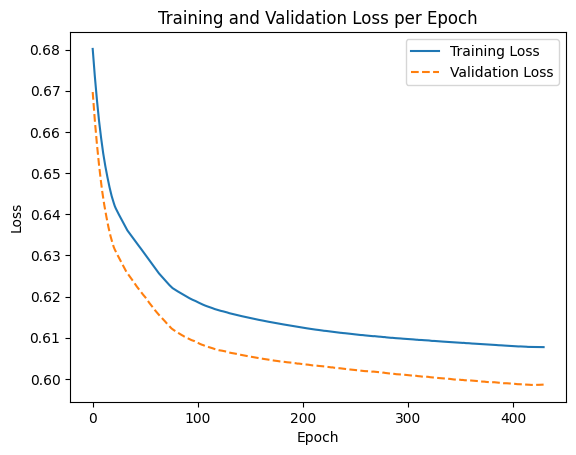

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

plt.plot(t_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

### 結果

In [63]:
test_data, _, _ = generate_data_all(A, int(args.n_students*0.5))
X_test = [X_test for X_test, _, _ in test_data]
y1_test = [y1_test for _, y1_test, _ in test_data]
y2_test = [y2_test for _, _, y2_test in test_data]
X_test = np.array(X_test)
y1_test = np.array(y1_test)
y2_test = np.array(y2_test)

def test_model(model, y1_test, y2_test):
    model.eval()
    y1_test = torch.tensor(y1_test, dtype=torch.float32).to(device)
    y2_test = torch.tensor(y2_test, dtype=torch.float32).to(device)
    relu = nn.ReLU()
    model_predict = []
    for i in range(len(y1_test)):
        c = torch.ones(n_skills, dtype=torch.float32, device=device)
        c = c - y1_test[i]
        state = y1_test[i].to(device)
        for _ in range(int(sum(y2_test[i]))):
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # 予算の更新
        # 最終的な出力を保存
        model_predict.append((state - y1_test[i]).detach().numpy())
    model_predict = np.array(model_predict)
    return model_predict

# 提案モデルの予測
proposed_model_predict = test_model(model, y1_test, y2_test)
# 上限モデルの予測
upper_model_predict = test_model(upper_model, y1_test, y2_test)
# stepモデルの予測
step_model_predict = test_model(step_model, y1_test, y2_test)
# allモデルの予測
all_model_predict = test_model(all_model, y1_test, y2_test)


def redistribute(p, total):
    p = np.array(p, dtype=np.float64)
    scaled = p * total
    clipped = np.minimum(scaled, 1.0)

    excess = total - clipped.sum()

    mask = clipped < 1.0
    clipped_part = clipped[mask]

    if excess > 0 and clipped_part.sum() > 0:
        weights = clipped_part / clipped_part.sum()
        clipped[mask] += weights * excess

    # 最終的に合計が total になるようにスケーリング
    if clipped.sum() > 0:
        clipped *= total / clipped.sum()

    return clipped

# 比較手法（遷移先の分布）
com_model_predict = []
total = 0
# 状態ごとの学生数をカウント（出現回数ベース）
state_counts = defaultdict(int)
for i in range(len(y1_data)):
    state_tuple = tuple(map(int, y1_data[i]))
    state_counts[state_tuple] += 1
for i in range(len(y1_test)):
    next_prob = np.zeros(n_skills)
    
    if sum(y2_test[i]) == 0:
        com_model_predict.append(next_prob)
        continue

    total = 0
    for j in range(n_skills):
        if y1_test[i][j] == 0:
            next_attribute = list(y1_test[i])
            next_attribute[j] = 1
            next_attribute = tuple(next_attribute)
            next_prob[j] = state_counts[next_attribute]
            total += state_counts[next_attribute]
    
    mask = (y1_test[i] == 0)
    if total == 0:
        next_prob[mask] =  1 / np.sum(mask) # 0部分に均等に
    else:
        next_prob = next_prob / total
    not_zero = (next_prob != 0)
    if not_zero.sum() < sum(y2_test[i]):
        next_prob[~(not_zero | mask)] = 0.0001
    next_prob = redistribute(next_prob, np.sum(y2_test[i]))
    com_model_predict.append(next_prob)
com_model_predict = np.array(com_model_predict)

In [64]:
def accuracy(model_predict, top_k):
    k = len(top_k)
    pred_top_k = set(np.argsort(model_predict)[-k:])
    return len(pred_top_k & top_k) / k

def CrossEntropy(model_predict, top_k):
    epsilon = 1e-10
    model_predict = np.where(model_predict == 0, epsilon, model_predict)
    return -np.mean(np.log(model_predict[list(top_k)]))

def d_score(model_predict, top_k, difficulties):
    score = 0
    for i in top_k:
        score += model_predict[i] / difficulties[i]
    return score / len(top_k)

def match_rate(model_predict, top_k):
    k = len(top_k)
    pred_top_k = set(np.argsort(model_predict)[-k:])
    return len(pred_top_k & top_k) / k

def AUC(model_predict, top_k, not_yet):
    auc = 0
    for skill in not_yet:
        if skill not in top_k:
            auc += 1 - model_predict[skill]
        else:
            auc += model_predict[skill]
    return auc / len(not_yet)

import numpy as np

def check_sum_consistency(vectors, tolerance=1e-6):
    """
    各ベクトルの合計値がすべて一致するか確認する。
    
    Parameters:
    - vectors: リストや配列のリスト（各要素が1次元ベクトル）
    - tolerance: 浮動小数点の許容誤差（デフォルトは 1e-6）

    Raises:
    - ValueError: 一致しないベクトルがある場合
    """
    if len(vectors) < 2:
        return  # 比較対象が1つ以下ならOKとする

    sums = [np.sum(v) for v in vectors]
    reference = sums[0]

    for idx, s in enumerate(sums[1:], start=1):
        if not np.isclose(s, reference, atol=tolerance):
            raise ValueError(f"Error: vector {idx} sum ({s}) is not equal to reference sum ({reference}) within tolerance {tolerance}.")

    # print("All vectors have consistent sums.")


y1_data = np.array(y1_data)
difficulties = np.sum(y1_data, axis=0) 
difficulties = difficulties / difficulties.sum()  # 正規化
# print(f"難易度ベースの分布: {difficulties}")

proposed_accuracies = []
upper_accuracies = []
step_accuracies = []
all_accuracies = []
random_accuracies = []
com_accuracies = []
difficulties_accuracies = []

proposed_scores = []
upper_proposed_scores = []
step_scores = []
all_scores = []
random_scores = []
com_scores = []
difficulties_scores = []

proposed_ce = []
upper_ce = []
step_ce = []
all_ce = []
random_ce = []
com_ce = []
difficulties_ce = []

proposed_auc = []
upper_auc = []
step_auc = []
all_auc = []
random_auc = []
com_auc = []
difficulties_auc = []

proposed_match_rate = []
upper_match_rate = []
step_match_rate = []
all_match_rate = []
for i in range(len(y2_test)):
    k = int(sum(y2_test[i]))  # 1の個数を取得（明示的に int に変換）
    if k == 0:
        continue  # 1がない場合はスキップ
    
    # 習得スキルのインデックス
    true_top_k = set(np.where(y2_test[i] == 1)[0])
    # 未習得部分
    not_yet = set(np.where(y1_test[i] == 0)[0])

    # 難易度ベース
    d_predict = np.zeros(n_skills)
    d_predict[list(not_yet)] = difficulties[list(not_yet)]
    difficulty_sum = sum(difficulties[j] for j in not_yet)
    d_predict[list(not_yet)] /= difficulty_sum
    d_predict = redistribute(d_predict, np.sum(y2_test[i]))
    d_top_k = set(np.argsort(d_predict)[-k:])
    # ランダムベース
    r_predict = np.zeros(n_skills)
    r_predict[list(not_yet)] = k / len(not_yet)

    check_sum_consistency([proposed_model_predict[i], upper_model_predict[i], step_model_predict[i], all_model_predict[i], r_predict, com_model_predict[i], d_predict])

    # 予測一致率
    proposed_accuracies.append(accuracy(proposed_model_predict[i], true_top_k))
    upper_accuracies.append(accuracy(upper_model_predict[i], true_top_k))
    step_accuracies.append(accuracy(step_model_predict[i], true_top_k))
    all_accuracies.append(accuracy(all_model_predict[i], true_top_k))
    random_accuracies.append(len(set(np.random.choice(list(set(np.where(y1_test[i] == 0)[0])), k, replace=False)) & true_top_k) / k)
    com_accuracies.append(accuracy(com_model_predict[i], true_top_k))
    difficulties_accuracies.append(accuracy(d_predict, true_top_k))

    # 難易度スコア
    proposed_scores.append(d_score(proposed_model_predict[i], true_top_k, d_predict))
    upper_proposed_scores.append(d_score(upper_model_predict[i], true_top_k, d_predict))
    step_scores.append(d_score(step_model_predict[i], true_top_k, d_predict))
    all_scores.append(d_score(all_model_predict[i], true_top_k, d_predict))
    random_scores.append(d_score(r_predict, true_top_k, d_predict))
    com_scores.append(d_score(com_model_predict[i], true_top_k, d_predict))
    difficulties_scores.append(d_score(d_predict, true_top_k, d_predict))

    # クロスエントロピー
    proposed_ce.append(CrossEntropy(proposed_model_predict[i], true_top_k))
    upper_ce.append(CrossEntropy(upper_model_predict[i], true_top_k))
    step_ce.append(CrossEntropy(step_model_predict[i], true_top_k))
    all_ce.append(CrossEntropy(all_model_predict[i], true_top_k))
    random_ce.append(CrossEntropy(r_predict, true_top_k))
    com_ce.append(CrossEntropy(com_model_predict[i], true_top_k))
    difficulties_ce.append(CrossEntropy(d_predict, true_top_k))

    # AUC
    proposed_auc.append(AUC(proposed_model_predict[i], true_top_k, not_yet))
    upper_auc.append(AUC(upper_model_predict[i], true_top_k, not_yet))
    step_auc.append(AUC(step_model_predict[i], true_top_k, not_yet))    
    all_auc.append(AUC(all_model_predict[i], true_top_k, not_yet))
    random_auc.append(AUC(r_predict, true_top_k, not_yet))
    com_auc.append(AUC(com_model_predict[i], true_top_k, not_yet))
    difficulties_auc.append(AUC(d_predict, true_top_k, not_yet))

    # 難易度ベースとの一致率
    proposed_match_rate.append(match_rate(proposed_model_predict[i], d_top_k))
    upper_match_rate.append(match_rate(upper_model_predict[i], d_top_k))
    step_match_rate.append(match_rate(step_model_predict[i], d_top_k))
    all_match_rate.append(match_rate(all_model_predict[i], d_top_k))

# 平均を計算（リストが空でない場合のみ）
average_proposed_accuracy = np.mean(proposed_accuracies) if proposed_accuracies else 0.0
average_upper_accuracy = np.mean(upper_accuracies) if upper_accuracies else 0.0
average_step_accuracy = np.mean(step_accuracies) if step_accuracies else 0.0
average_all_accuracy = np.mean(all_accuracies) if all_accuracies else 0.0
average_random_accuracy = np.mean(random_accuracies) if random_accuracies else 0.0
average_com_accuracy = np.mean(com_accuracies) if com_accuracies else 0.0
average_difficulties_accuracy = np.mean(difficulties_accuracies) if difficulties_accuracies else 0.0

average_proposed_score = np.mean(proposed_scores) if proposed_scores else 0.0
average_upper_proposed_score = np.mean(upper_proposed_scores) if upper_proposed_scores else 0.0
average_step_score = np.mean(step_scores) if step_scores else 0.0
average_all_score = np.mean(all_scores) if all_scores else 0.0
average_random_score = np.mean(random_scores) if random_scores else 0.0
average_com_score = np.mean(com_scores) if com_scores else 0.0
average_difficulties_score = np.mean(difficulties_scores) if difficulties_scores else 0.0

average_proposed_ce = np.mean(proposed_ce) if proposed_ce else 0.0
average_upper_ce = np.mean(upper_ce) if upper_ce else 0.0
average_step_ce = np.mean(step_ce) if step_ce else 0.0
average_all_ce = np.mean(all_ce) if all_ce else 0.0
average_random_ce = np.mean(random_ce) if random_ce else 0.0
average_com_ce = np.mean(com_ce) if com_ce else 0.0
average_difficulties_ce = np.mean(difficulties_ce) if difficulties_ce else 0.0

average_proposed_auc = np.mean(proposed_auc) if proposed_auc else 0.0
average_upper_auc = np.mean(upper_auc) if upper_auc else 0.0
average_step_auc = np.mean(step_auc) if step_auc else 0.0
average_all_auc = np.mean(all_auc) if all_auc else 0.0
average_random_auc = np.mean(random_auc) if random_auc else 0.0
average_com_auc = np.mean(com_auc) if com_auc else 0.0
average_difficulties_auc = np.mean(difficulties_auc) if difficulties_auc else 0.0

average_proposed_match_rate = np.mean(proposed_match_rate) if proposed_match_rate else 0.0
average_upper_match_rate = np.mean(upper_match_rate) if upper_match_rate else 0.0
average_step_match_rate = np.mean(step_match_rate) if step_match_rate else 0.0
average_all_match_rate = np.mean(all_match_rate) if all_match_rate else 0.0

print("---Accuracy---")
print(f"proposed accuracy: {average_proposed_accuracy:.4f}")
print(f"upper accuracy: {average_upper_accuracy:.4f}")
print(f"step accuracy: {average_step_accuracy:.4f}")
print(f"all accuracy: {average_all_accuracy:.4f}")
print(f"random accuracy: {average_random_accuracy:.4f}")
print(f"comparison accuracy: {average_com_accuracy:.4f}")
print(f"difficulties accuracy: {average_difficulties_accuracy:.4f}")

print("---Score---")
print(f"proposed score: {average_proposed_score:.4f}")
print(f"upper proposed score: {average_upper_proposed_score:.4f}")
print(f"step score: {average_step_score:.4f}")
print(f"all score: {average_all_score:.4f}")
print(f"random score: {average_random_score:.4f}")
print(f"comparison score: {average_com_score:.4f}")
print(f"difficulties score: {average_difficulties_score:.4f}")

print("---Cross Entropy---")
print(f"proposed CE: {average_proposed_ce:.4f}")
print(f"upper CE: {average_upper_ce:.4f}")
print(f"step CE: {average_step_ce:.4f}")
print(f"all CE: {average_all_ce:.4f}")
print(f"random CE: {average_random_ce:.4f}")
print(f"comparison CE: {average_com_ce:.4f}")
print(f"difficulties CE: {average_difficulties_ce:.4f}")

print("---AUC---")
print(f"proposed AUC: {average_proposed_auc:.4f}")
print(f"upper AUC: {average_upper_auc:.4f}")
print(f"step AUC: {average_step_auc:.4f}")
print(f"all AUC: {average_all_auc:.4f}")
print(f"random AUC: {average_random_auc:.4f}")
print(f"comparison AUC: {average_com_auc:.4f}")
print(f"difficulties AUC: {average_difficulties_auc:.4f}")

print("---Match Rate---")
print(f"proposed match rate: {average_proposed_match_rate:.4f}")
print(f"upper match rate: {average_upper_match_rate:.4f}")
print(f"step match rate: {average_step_match_rate:.4f}")
print(f"all match rate: {average_all_match_rate:.4f}")


---Accuracy---
proposed accuracy: 0.7977
upper accuracy: 0.8511
step accuracy: 0.8394
all accuracy: 0.8511
random accuracy: 0.6138
comparison accuracy: 0.5480
difficulties accuracy: 0.7977
---Score---
proposed score: 1.1136
upper proposed score: 1.1446
step score: 1.1445
all score: 1.1400
random score: 0.9391
comparison score: 0.8612
difficulties score: 1.0000
---Cross Entropy---
proposed CE: 0.4587
upper CE: 0.4281
step CE: 0.4457
all CE: 0.4393
random CE: 0.5865
comparison CE: 6.6190
difficulties CE: 0.4821
---AUC---
proposed AUC: 0.8224
upper AUC: 0.8352
step AUC: 0.8270
all AUC: 0.8220
random AUC: 0.7172
comparison AUC: 0.6884
difficulties AUC: 0.7664
---Match Rate---
proposed match rate: 1.0000
upper match rate: 0.8975
step match rate: 0.9396
all match rate: 0.8760


In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_components):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_components)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    if state == (1,) * (num_components):  # 最後のノードでは遷移がないのでスキップ
        continue
    
    probabilities = transition_probabilities(A, np.array(state))
    c_g = torch.ones(num_components, dtype=torch.float32)
    c_g = c_g - torch.tensor(state, dtype=torch.float32)  # 予算を更新
    print(c_g)
    print(torch.tensor([state], dtype=torch.float32))
    state_tensor = torch.tensor(state, dtype=torch.float32)
    print(state_tensor[1])
    predicted_values = model(state_tensor, c_g)  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_components):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"({probabilities[i]:.2f})"
                predicted_value = f"{predicted_values[i]:.2f}"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{predicted_value}\n{transition_probability}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
# plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
# plt.text(
#     0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
#     "edges: predicted probability\n (): true probability",  # 表示したいテキスト
#     horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
#     verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
#     transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
#     fontsize=12,                    # フォントサイズ
#     color="black"                   # テキストの色
# )

# plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")

NameError: name 'states' is not defined

In [30]:
# 表示オプションを設定（有効数字3桁）
torch.set_printoptions(precision=3, sci_mode=False)
print(A)
for param in model.parameters():
    print(param)

for param in upper_model.parameters():
    print(param)

for param in step_model.parameters():
    print(param)

for param in all_model.parameters():
    print(param)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 1. 1. 0.]]
Parameter containing:
tensor([[     0.001,     -0.002,     -0.001,      0.001,     -0.000,     -0.000,
              0.001,     -0.001,     -0.001,      0.003],
        [     0.013,     -0.000,      0.001,     -0.000,     -0.000,      0.002,
             -0.001,     -0.001,     -0.002,     -0.003],
        [     0.237,      0.034,      0.001,      0.000,      0.002,     -0.001,
             -0.001,      0.001,      0.000,     -0.001],
        [     0.140,      0.301,      0.039,      0.003,      0.005,      0.002,
             -0.001,      0.000,     -0.001,      0.001],
        [     0.006,      0.004,      0.020,      0.002,      0.001,      0.002,
          